In [1]:
import os
import glob
import pandas as pd
import plotly as py
import cufflinks as cf
%matplotlib inline

In [2]:
path_to_csv = "/home/SharedFolder/trained_models/night-drive/weather_classifier/with_cloudy/train_A_over"
plot_title = "train_A_over"

In [3]:
csv_files = glob.glob(path_to_csv + "/*.csv")

### Combine CSVs into one DataFrame ###

In [4]:
df = pd.DataFrame()
for csv_file in csv_files:
    df = pd.concat([df, pd.read_csv(csv_file)], axis = 0)
df = df.reset_index(drop = True)

### Some preprocessing ###

In [5]:
df = df.drop(columns = ["weights"])
df.head()

,epoch,data,f1_score_weighted,f1_score_micro,f1_score_macro,accuracy,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,1,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.221325,0.197,0.195912,0.197,0.518631,0.683924,0.251190,0.409943,0.103860
1,2,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.619466,0.547,0.399305,0.547,0.802534,0.763355,0.520146,0.496273,0.240598
2,3,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.726253,0.688,0.482437,0.688,0.884549,0.799759,0.695791,0.559145,0.316566
3,4,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.752039,0.725,0.508155,0.725,0.902998,0.813542,0.744056,0.583676,0.351981
4,5,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.756880,0.728,0.517213,0.728,0.903501,0.818481,0.744940,0.605606,0.361494


In [6]:
df.data = df.data.apply(lambda x: x.split(os.sep)[-1].split(".json")[0].split("bdd100k_sorted_")[-1])
df = df.sort_values(by = ["data", "epoch"])
df = df.reset_index(drop = True)
df.head()

,epoch,data,f1_score_weighted,f1_score_micro,f1_score_macro,accuracy,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,1,test,0.503205,0.4545,0.470386,0.4545,0.746102,0.813652,0.525421,0.626778,0.343975
1,2,test,0.704244,0.6665,0.612181,0.6665,0.882567,0.885969,0.730456,0.725964,0.519549
2,3,test,0.768744,0.7490,0.674831,0.7490,0.919087,0.909102,0.804422,0.769663,0.599961
3,4,test,0.784346,0.7700,0.693624,0.7700,0.928441,0.915529,0.824570,0.781981,0.623323
4,5,test,0.789984,0.7745,0.699620,0.7745,0.931078,0.919388,0.829724,0.791572,0.631596


### Load training log file ###

In [7]:
train_log_file = glob.glob(path_to_csv + "/*.txt")
assert(len(train_log_file) == 1)

In [8]:
df_loss = pd.read_csv(train_log_file[0], sep = " ", header = None, skiprows = [0, 1])
df_loss.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,Epoch,"1/40,",Batch,10/403:,Train,Loss,=,1.535,Valid,Loss,=,1.539,ETA,=,6.67h
1,Epoch,"1/40,",Batch,20/403:,Train,Loss,=,1.538,Valid,Loss,=,1.505,ETA,=,6.21h
2,Epoch,"1/40,",Batch,30/403:,Train,Loss,=,1.452,Valid,Loss,=,1.444,ETA,=,5.17h
3,Epoch,"1/40,",Batch,40/403:,Train,Loss,=,1.412,Valid,Loss,=,1.410,ETA,=,5.40h
4,Epoch,"1/40,",Batch,50/403:,Train,Loss,=,1.375,Valid,Loss,=,1.358,ETA,=,5.17h


In [9]:
df_loss = df_loss.iloc[:, [1, 3, 7, 11]].rename(columns = {1: "epoch", 3: "batch", 7: "train_loss", 11: "train_dev_loss"})
df_loss.epoch = df_loss.epoch.apply(lambda x: int(x.split("/")[0]))
df_loss.batch = df_loss.batch.apply(lambda x: int(x.split("/")[0]))
df_loss["global_batch"] = (df_loss.epoch - 1) * df_loss.batch.max() + df_loss.batch
df_loss = df_loss.sort_values(by = ["epoch", "batch"]).set_index("global_batch", drop = True)
df_loss.head()

,epoch,batch,train_loss,train_dev_loss
global_batch,,,,
10,1,10,1.535,1.539
20,1,20,1.538,1.505
30,1,30,1.452,1.444
40,1,40,1.412,1.410
50,1,50,1.375,1.358


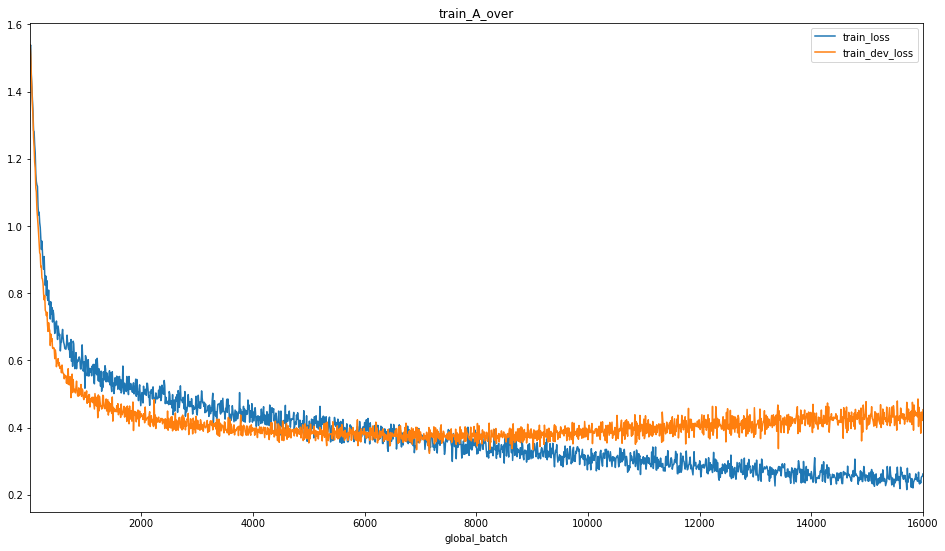

In [10]:
df_loss.plot(y = ["train_loss", "train_dev_loss"], title = plot_title, figsize = (16, 9))

### Combine loss, scores  and plot ###

In [11]:
df_combined = df_loss.groupby(by = ["epoch"]).median()
df_combined = df_combined.drop(columns = ["batch"])
df_combined.head()

,train_loss,train_dev_loss
epoch,,
1,0.9600,0.8790
2,0.6555,0.5620
3,0.5810,0.4930
4,0.5420,0.4590
5,0.5150,0.4445


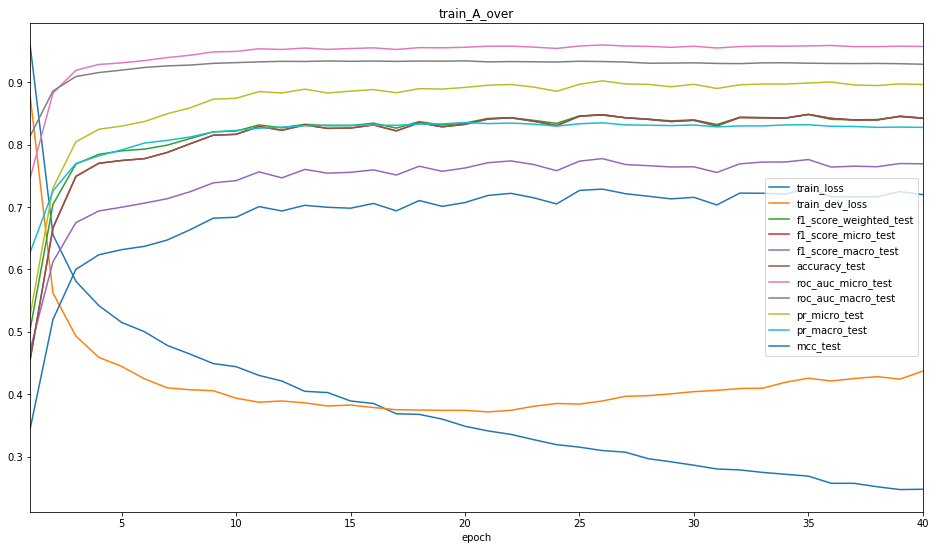

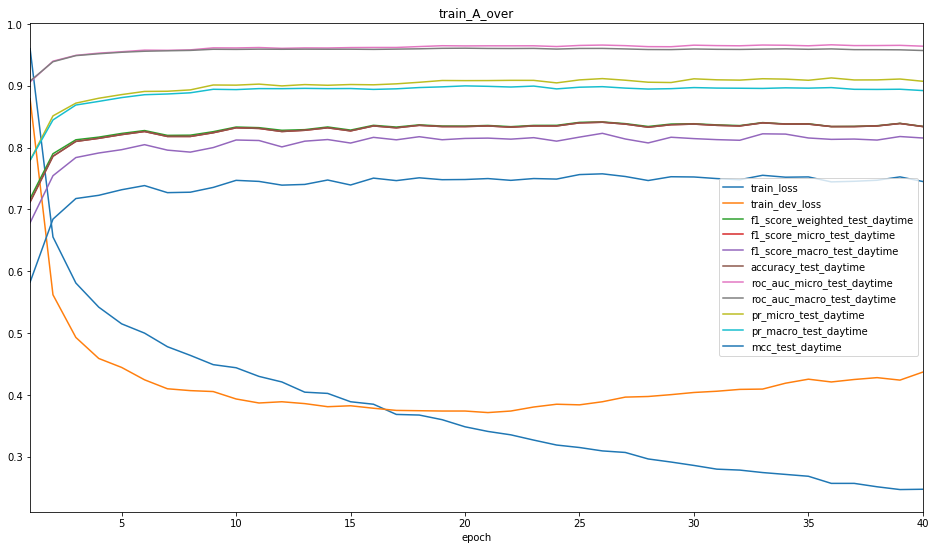

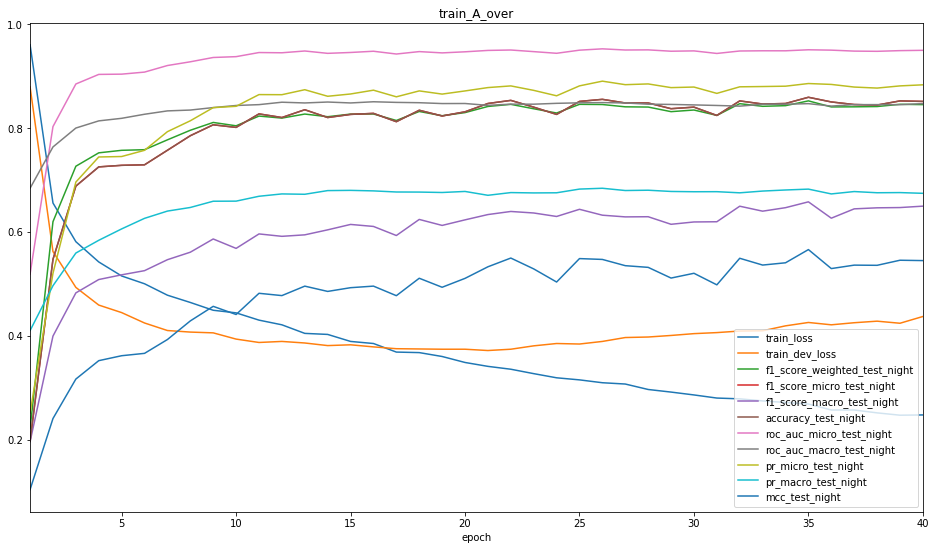

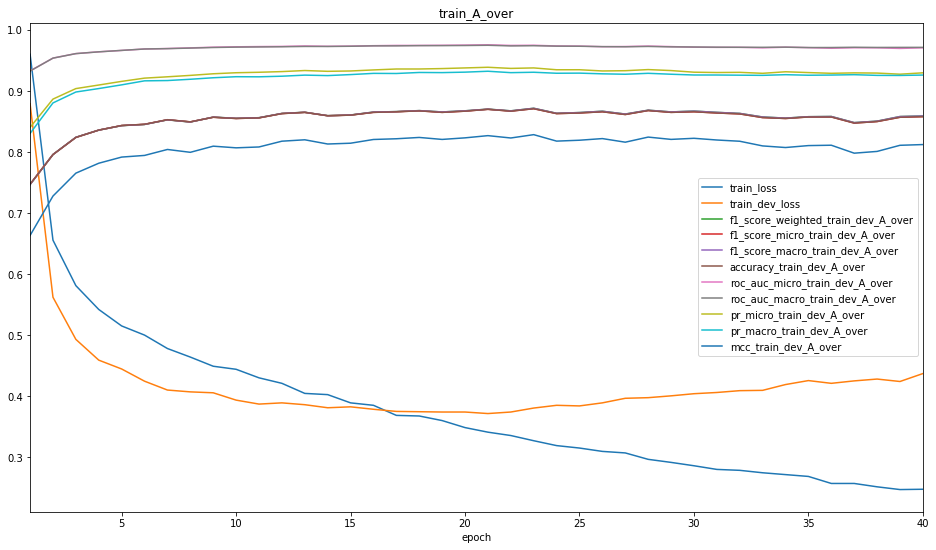

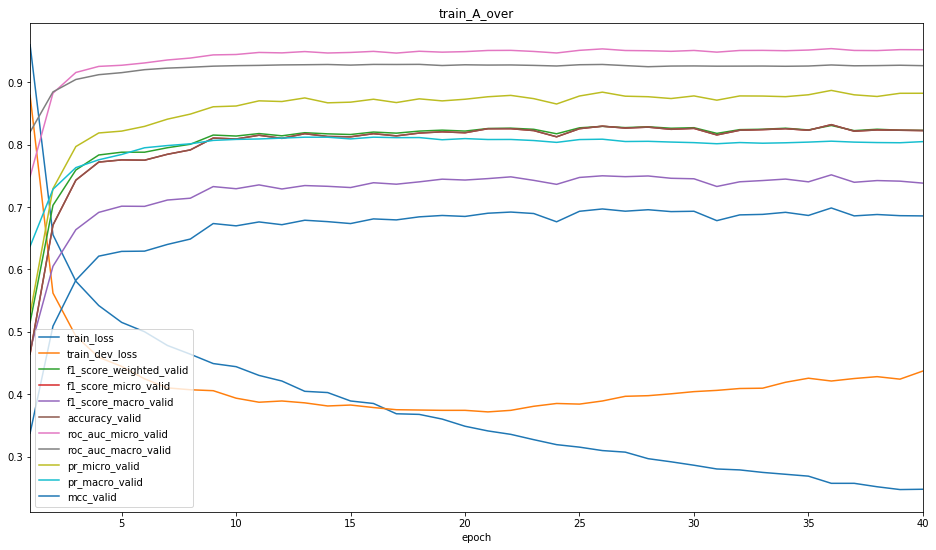

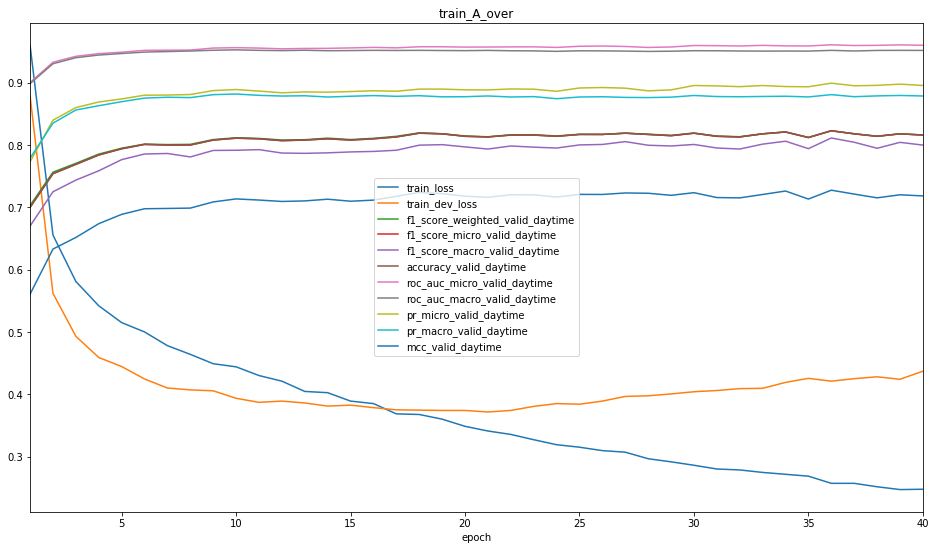

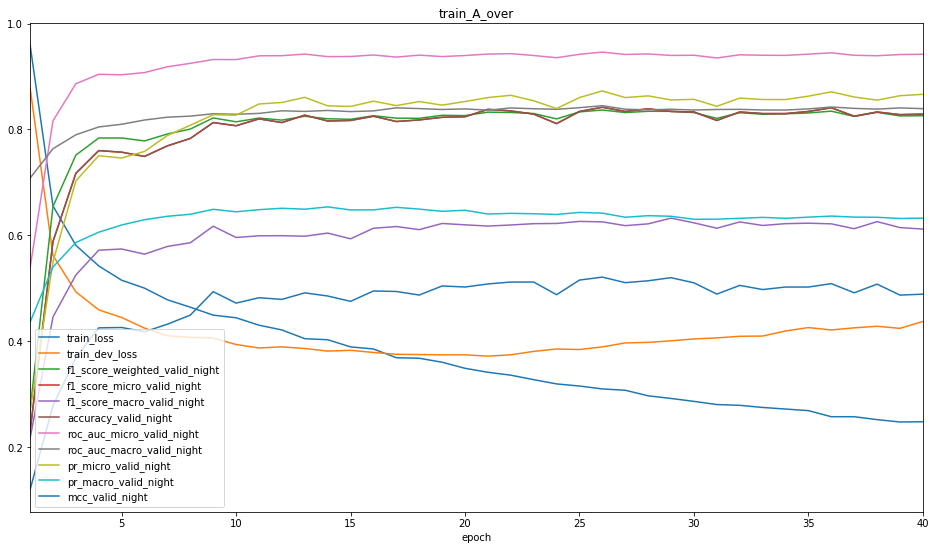

In [12]:
for data in df.data.unique():
    df_data = df.loc[df.data == data]
    df_data = df_data.drop(columns = ["data"])
    df_data = df_data.set_index("epoch", drop = True)
    df_data = df_data.add_suffix("_" + data)
    df_combined_data = df_combined.merge(df_data, on = "epoch")
    df_combined_data.plot(title = plot_title, figsize = (16, 9))

### Interactive Plotly Plots ##

In [13]:
cf.go_offline(connected = True)
config = {
    "modeBarButtonsToRemove": ["sendDataToCloud"],
    "displaylogo": False
}
layout = {
    "title": plot_title,
    "xaxis": {
        "title": "epoch"
    },    
    "width": 960,
    "height": 540
}
for data in df.data.unique():
    df_data = df.loc[df.data == data]
    df_data = df_data.drop(columns = ["data"])
    df_data = df_data.set_index("epoch", drop = True)
    df_data = df_data.add_suffix("_" + data)
    df_combined_data = df_combined.merge(df_data, on = "epoch")
    fig = df_combined_data.iplot(layout = layout, asFigure = True)
    py.offline.iplot(fig, show_link = False, config = config)